# Segmentación de imágenes básica

Implementación basada en guía de segmentación de imagenes de Tensorflow, bajo la licencia https://www.apache.org/licenses/LICENSE-2.0 

La segmentación de imágenes es un desafio que deriva de la clasificación de imagenes. Bajo este enfoque, el modelo debe clasificar los pixeles de la imagen para determinar si es parte del fondo o de los elementos a identificar. 

Para esta implementación, se usa el dataset de mascotas de oxford "oxford_iiit_pet" bajo la licencia CC 4.0 https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet?hl=es-419 . Este dataset contiene imágenes de mascotas de 37 categorías con aproximadamente 200 imágenes para cada clase, y cuenta con una máscara incluida para cada imagen, en la que se distingue a la mascota, al borde de la mascota y al fondo de la imagen con distintos colores.

El objetivo de esta implementación será utilizar un modelo U-Net para identificar 3 categorías diferentes en la imagen:

1: Pixel que forma parte de la mascota

2: Pixel que forma parte del borde de la mascota

3: Pixel que pertenece al fondo de la imagen


## Cargar el dataset y preprocesarlo

In [46]:
#instalamos la librería de ejemplos de tensoflow, la cual contiene una implementación de un upscaler que utilizaremos
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

#importamos librerías de tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#importaremos el dataset de mascotas a través de la librería de tensorflow
import tensorflow_datasets as tfds
#importamos utilidades adicionales
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-z99o_ehr
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-z99o_ehr
  Resolved https://github.com/tensorflow/examples.git to commit b0b0e9d0cf74a7f7dc84ab4ace616121dc5acc1a
  Preparing metadata (setup.py) ... done


In [47]:
#cargamos el dataset y su información adicional a través de la librería dfds de tensorflow
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


A continuación, vamos a definir funciones que nos permitirán manipular el dataset a conveniencia, modificando su tamaño, normalizando sus valores y aplicando data augmentation en los datos de entrenamiento

In [48]:
#función para ajustar el tamaño de la imagen
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [49]:
#función de data augmentation sencilla
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Solamente se aplican tecnicas de invertir la imagen, ya que otras transformaciones van a meter ruido que no permitirá detectar máscaras correctamente
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [50]:
#función para normalizar los valores de la máscara y la imagen
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [51]:
#función para aplicar todas las modificaciones previas al dataset de train
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

#funcion que no aplica data augmentation, para dataset de test
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

A continuación, aplicaremos las funciones para generar los datasets de train y test. Lo haremos usando un map sobre la división de train y test ya existente en el dataset original

In [52]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

Ahora vamos a continuar con el preprocesado, aplicando las siguientes técnicas sobre el train dataset:

cache(): Se almacena en caché el conjunto de datos de entrenamiento. Mejora el rendimiento al evitar que los datos se lean de disco en cada época de entrenamiento.

shuffle(BUFFER_SIZE): Los elementos del dataset se mezclan de manera aleatoria utilizando el tamaño de búfer especificado.

batch(BATCH_SIZE): Los elementos se agrupan en batches del tamaño especificado.
repeat(): El conjunto de datos se repite indefinidamente, para múltiples épocas de entrenamiento.

prefetch(): sirve para cargar automáticamente el próximo batch de datos en segundo plano mientras se entrena con el batch actual. 

Sobre test, solamente tomamos la cantidad de imagenes del set de pruebas y las agrupamos en batches del tamaño especificado. 


In [53]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
#se aplican las técnicas descritas previamente
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_batches = test_dataset.take(3669).batch(BATCH_SIZE)

Listo! hemos preparado el dataset para el entrenamiento. Ahora vamos a visualizar una imagen random del set junto con su máscara

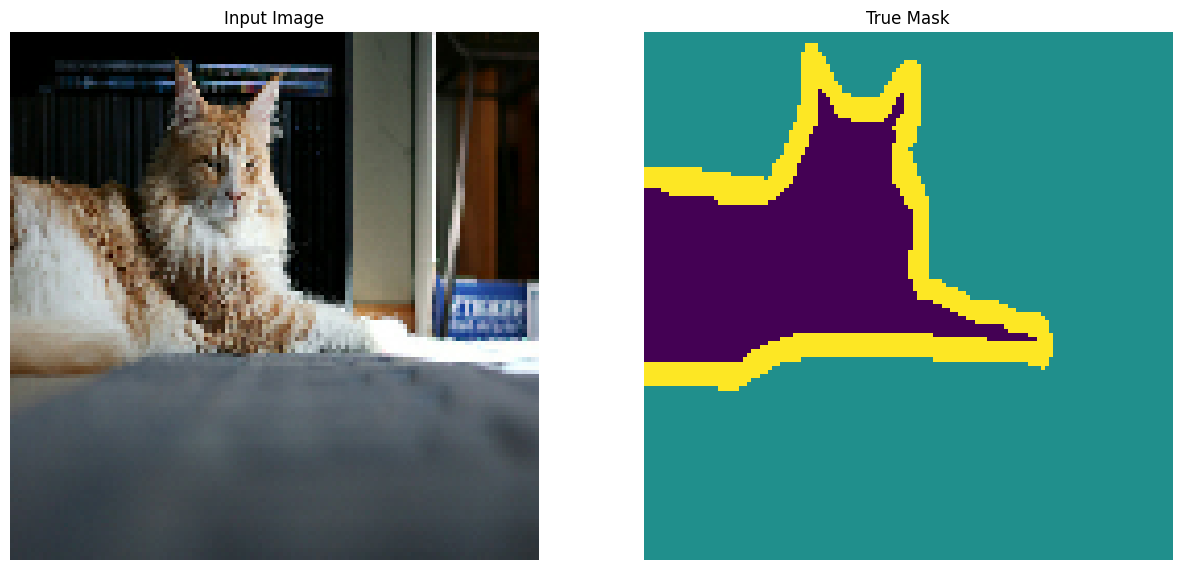

In [55]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Implementar el modelo

Para la segmentación vamos a utilizar un modelo de tipo U-Net. Se llama así debido a su forma característica similar a la letra "U".  Estos modelo consisten en un encoder (downsampler) y un decoder (upsampler).

El modelo U-Net utiliza el encoder para extraer características y el decoder para reconstruir una máscara de segmentación detallada. A medida que el encoder reduce la resolución espacial, guarda copias de las características en diferentes etapas en una estructura llamada "conexiones de salto" (skip connections). Las conexiones de salto ayudan a preservar detalles finos y mejorar el rendimiento de la segmentación.

Para no partir desde cero y utilzar una base robusta, se utiliza como base el modelo Mobile Net V2 y lo aumentaré para asemejarlo a un modelo U Net. 

In [85]:
# Se importa el modelo base
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Capas que seran utilizadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
# outputs del modelo base
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Crear un modelo para feature extraction
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

El decoder/upsampler consiste en upsample blocks que ya están implementados en la librería TensorFlow examples

In [86]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Ahora creamos el modelo U-Net, implementando las fases de downsampling, skip connections y upsampling

In [87]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling, aqui se recupera MobileNet 
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling y skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # Capa final del modelo
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Entrenar el modelo

Ahora podemos proceder a entrenar el modelo. Esto lo haremos utilizando un clasificador categorico, ya que tenemos 3 clases a detectar (mascota, borde de mascota y fondo)

In [88]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
#función que construye la máscara en base a la predicción
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [90]:
#función que muestra una predicción utilizando el modelo
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Ahora que ya tenemos una forma de visualizar la predicción, vamos a ver que predicciones hace el modelo en su estado actual, es decir, utilizando solo los pesos de mobile net sin entrenamiento específico para estas clases

1/1 [==============================] - 2s 2s/step


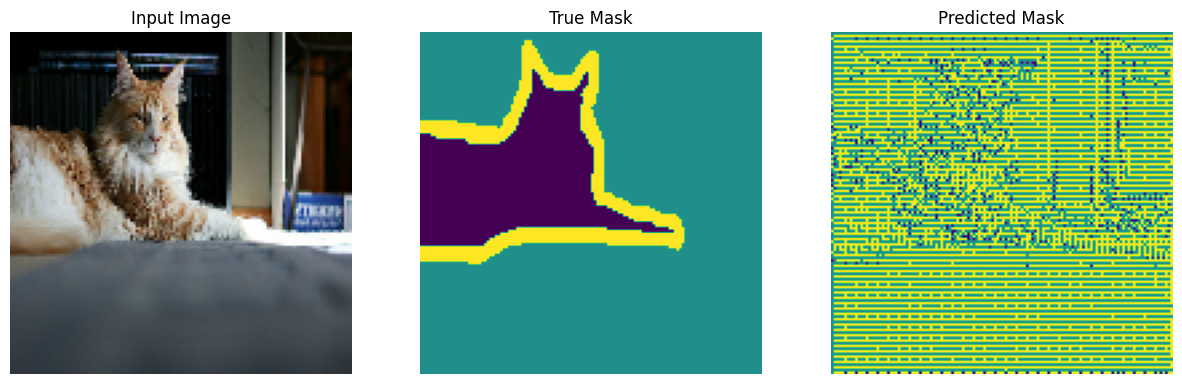

In [91]:
show_predictions()

Vemos que la predicción dista mucho de lo esperado, es posible distinguir con dificultad la forma de la mascota en la máscara de predicción. 

Ahora entrenemos el modelo para nuestras clases, y veamos el resultado

In [84]:
#función para imprimir la predicción conforme avanzan las epicas de entrenamiento
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nPredicción en la época #{}\n'.format(epoch+1))

1/1 [==============================] - 0s 23ms/step


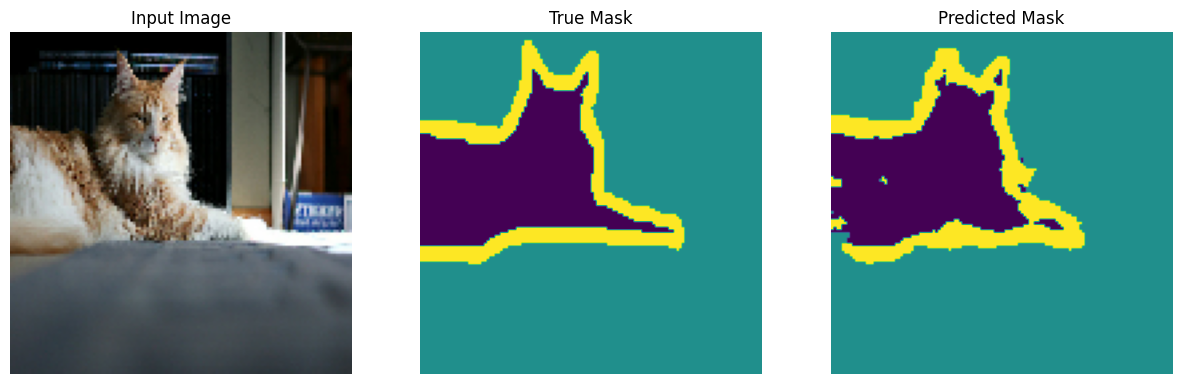


Predicción en la época #30

200/200 [==============================] - 24s 118ms/step - loss: 0.0269 - accuracy: 0.9889


In [93]:
#Entrenamiento del modelo
EPOCHS = 30
BUFFER_SIZE = 1000

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=200,
                          callbacks=[DisplayCallback()])

Vemos una importante mejora en la generación de la máscara. Ahora procedamos a revisar el loss del modelo y a evaular con el conjunto de pruebas

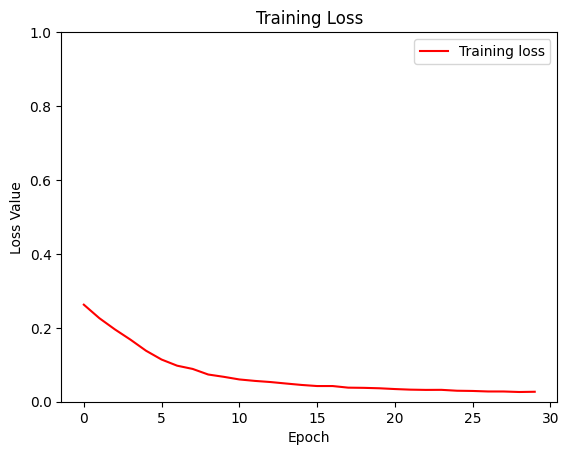

In [94]:
loss = model_history.history['loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Por último, probamos el modelo con el set de test para evaluar su desempeño

In [95]:
#los steps necesarios para revisar todo el dataset de test
test_loss = model.evaluate(test_batches, steps = 58)


58/58 [==============================] - 14s 228ms/step - loss: 0.7709 - accuracy: 0.8907


Vemos que el accuracy en train 